In [16]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import time
import sys
import os

import seaborn as sns
import matplotlib.dates as mdates
from datetime import datetime, date

# preamble for jupyter notebook and django
import django
import platform

if platform.node() == "srv-mcc-apsis":
    sys.path.append("/home/muef/tmv/BasicBrowser/")
    #sys.path.append('/home/leey/tmv/BasicBrowser/')
    dtm_path = "/home/galm/software/dtm/dtm/main"
else:
    # local paths
    sys.path.append('/media/Data/MCC/tmv/BasicBrowser/')
    dtm_path = "/home/finn/dtm/dtm/main"

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

# import from appended path
import parliament.models as pm
from parliament.tasks import do_search, run_tm, combine_searches
import cities.models as cmodels
from django.contrib.auth.models import User
from tmv_app.models import *
import scoping.models as sm
from utils.tm_mgmt import update_topic_scores
from django.db.models import Q, Count, Func, F, Sum, Avg, Value as V
from django.db.models.functions import TruncDate, TruncMonth, TruncYear

from utils.topic_comparison import compare_topic_queryset, save_res, sort_matrix, draw_score_matrix
from utils.topic_comparison import save_topic_list_as_table, draw_bipartite_topic_graph, bipartite_graph_from_matrix

In [2]:
runs = RunStats.objects.filter(psearch__id=89, method='BD', top_chain_var=0.01, status=3).order_by('alpha')

run_ids = [run.run_id for run in runs]
run_df = pd.DataFrame.from_dict(runs.values('run_id', 'K', 'alpha',
                                'top_chain_var', 'rng_seed', 'max_iter', 'psearch__id', 'coherence', 'exclusivity',))

#run_df.set_index('run_id')
run_df = run_df.sort_values('run_id').set_index('run_id')
#run_df[run_df["K"]== 45]
run_df

,K,alpha,coherence,exclusivity,max_iter,psearch__id,rng_seed,top_chain_var
run_id,,,,,,,,
2155,45,0.01,0.464178,0.878157,50,89,1,0.01
2156,45,0.05,0.473385,0.912385,50,89,1,0.01
2157,45,0.10,0.482888,0.901765,50,89,1,0.01
2350,35,0.01,0.419955,0.804016,200,89,1,0.01
2351,40,0.01,0.458939,0.868018,200,89,1,0.01
2352,45,0.01,0.480687,0.928956,200,89,1,0.01
2353,40,0.05,0.467016,0.869076,200,89,1,0.01
2363,40,0.02,0.461092,0.861722,200,89,1,0.01
2383,35,0.05,NaN,NaN,200,89,1,0.01


In [3]:
Topic.objects.filter(run_id=2155).values('id')

<QuerySet [{'id': 178500}, {'id': 178506}, {'id': 178504}, {'id': 178495}, {'id': 178473}, {'id': 178483}, {'id': 178486}, {'id': 178472}, {'id': 178477}, {'id': 178480}, {'id': 178498}, {'id': 178507}, {'id': 178505}, {'id': 178502}, {'id': 178508}, {'id': 178511}, {'id': 178482}, {'id': 178512}, {'id': 178497}, {'id': 178503}, '...(remaining elements truncated)...']>

# get similarity matrices

In [4]:
from sklearn.metrics.pairwise import cosine_similarity

def topic_cosine_similarity(run_ids, period='all'):

    df = pd.DataFrame.from_dict(TopicTerm.objects.filter(run_id__in=run_ids).order_by('run_id', '-topic__score').values('topic', 'term__title', 'score', 'PY'))
    
    if period == 'all':
        # sum over periods
        df = df.groupby(['topic', 'term__title']).sum()
    else:
        #  select period
        df = df[df['PY'] == period].groupby(['topic', 'term__title']).sum()

    sdf = df['score'].unstack(level=0, fill_value=0).to_sparse(fill_value=0)
    print("word matrix density: {}".format(sdf.density))
    
    sim = cosine_similarity(sdf.values.T)
    topic_ids = [topic_id for topic_id in sdf.columns]
    
    print("shape: {}".format(sim.shape))
    return sim, topic_ids

from sklearn.metrics.pairwise import linear_kernel

def topic_topword_overlap(run_ids, period='all', no_topwords=20):

    tw_dicts = []
    for t in Topic.objects.filter(run_id__in=run_ids).order_by('run_id','-score'):
        
        if not t.top_words:
            print("assign top words (average, not taking topic shares into account!) for topic {}".format(t))
            terms = Term.objects.filter(topicterm__topic=t).values('title').annotate(
                        summed_score = Sum(F('topicterm__score'))).order_by('-summed_score')[:no_topwords]
            term_list = [term['title'] for term in terms]
            t.top_words = term_list
            t.save()

        for term in t.top_words:
            tw_dicts.append({'topic': t.id, 'term': term, 'value': 1}) 

    df = pd.DataFrame.from_dict(tw_dicts)

    df = df.groupby(['topic', 'term']).sum()

    df = df['value'].unstack(level=0, fill_value=0)
    
    sim = linear_kernel(df.values.T)
    topic_ids = [topic_id for topic_id in df.columns]

    print("shape: {}".format(sim.shape))
    
    return sim, topic_ids

In [5]:
save_dir = "./plots/bipartite_graphs/"

In [6]:
# run ids need to be provided in ascending order
run_ids = [2350, 2661]
#runs = [2155, 2156, 2157]
runs = RunStats.objects.filter(run_id__in=run_ids).order_by('run_id')
run_ids = [run.run_id for run in runs]
Ks = [run.K for run in runs]
tk = np.array(Ks).cumsum()
#topic_labels = {item['id']: item['title'] for item in Topic.objects.filter(run_id__in=selected_run_ids).values('title', 'id')}
print(run_ids)
print(Ks)
print(tk)

[2350, 2661]
[35, 35]
[35 70]


word matrix density: 0.07158945724695973
shape: (70, 70)


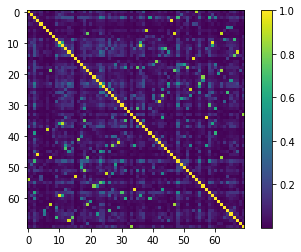

In [7]:
cos_sim, topic_ids_cos = topic_cosine_similarity(run_ids)
plt.imshow(cos_sim)
plt.colorbar()

assign top words (average, not taking topic shares into account!) for topic {red, tun, wirklich}
assign top words (average, not taking topic shares into account!) for topic {darauf, bereich, natur}
assign top words (average, not taking topic shares into account!) for topic {wirtschaft, entwickl, bundesregier}
assign top words (average, not taking topic shares into account!) for topic {polit, freiheit, staat}
assign top words (average, not taking topic shares into account!) for topic {million, milliard, haushalt}
assign top words (average, not taking topic shares into account!) for topic {wirtschaft, deutschland, wachstum}
assign top words (average, not taking topic shares into account!) for topic {euro, sozialpolit, milliard}
assign top words (average, not taking topic shares into account!) for topic {deutsch, deutschland, franzos}
assign top words (average, not taking topic shares into account!) for topic {energi, erneuerbar, kohl}
assign top words (average, not taking topic shares in

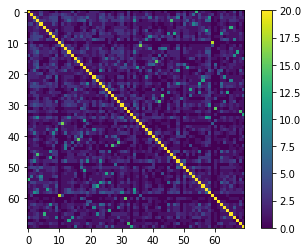

In [8]:
overlap_sim, topic_ids_overlap = topic_topword_overlap(run_ids)
plt.imshow(overlap_sim)
plt.colorbar()

# sort topics according to match

matching sum:	23.741983511889
max rows:	25.00696364090212
max cols:	25.884393593975233


0

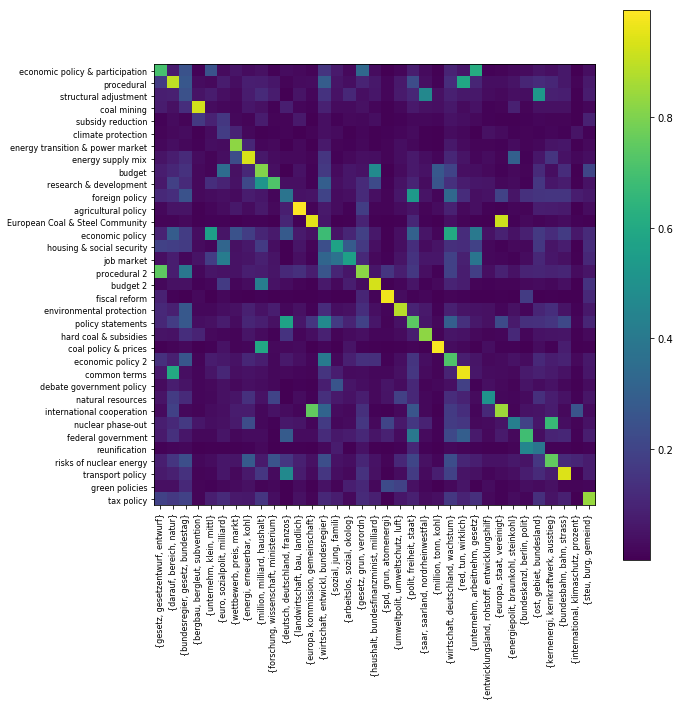

In [10]:
K_run_id = [run.K for run in RunStats.objects.filter(run_id__in=run_ids).order_by('run_id')]
if K_run_id[0] > K_run_id[1]:
    corr_matrix = cos_sim[tk[0]:tk[1], :tk[0]]
    topics1 = [Topic.objects.get(id=topic_id) for topic_id in topic_ids_cos[tk[0]:tk[1]]]
    topics2 = [Topic.objects.get(id=topic_id) for topic_id in topic_ids_cos[0:tk[0]]]
else:
    corr_matrix = cos_sim[tk[0]:tk[1], :tk[0]].T
    topics1 = [Topic.objects.get(id=topic_id) for topic_id in topic_ids_cos[0:tk[0]]]
    topics2 = [Topic.objects.get(id=topic_id) for topic_id in topic_ids_cos[tk[0]:tk[1]]]
    
filename = "cosine_similarity_matrix_runs_{}_{}.png".format(run_ids[0], run_ids[1])
draw_score_matrix(corr_matrix, topics1, topics2, match=True, filename=os.path.join(save_dir, filename))

matching sum:	360.0
max rows:	382.0
max cols:	382.0


0

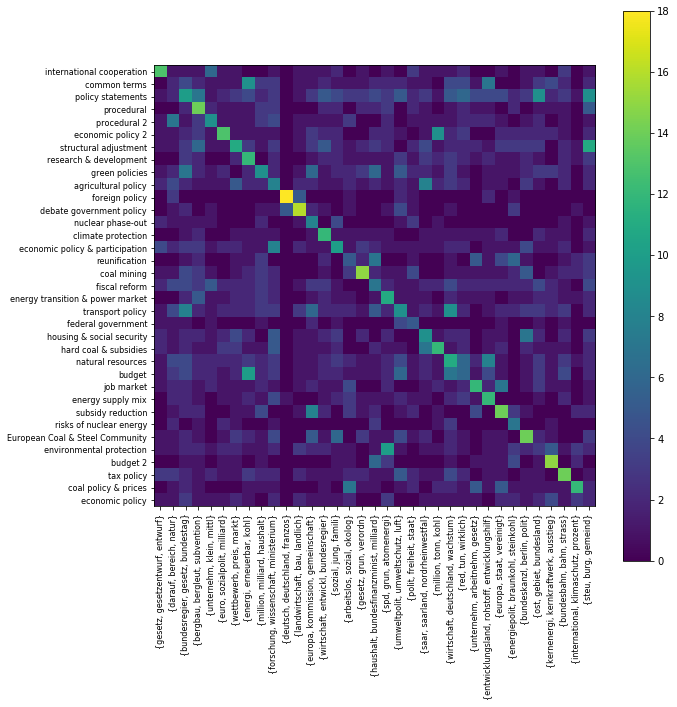

In [11]:
filename = "top_word_overlap_matrix_runs_{}_{}.png".format(run_ids[0], run_ids[1])
draw_score_matrix(overlap_sim[tk[0]:tk[1], :tk[0]], topics1, topics2, match=True, filename=os.path.join(save_dir, filename))

# todo: in draw function, sort according to topic scores for one model

# plot bipartite graph

matching sum:	23.741983511889003
max rows:	25.884393593975233
max cols:	25.00696364090212
Topic labels: {0: <Topic: {umweltpolit, umweltschutz, luft}>, 1: <Topic: {unternehm, arbeitnehm, gesetz}>, 2: <Topic: {wirtschaft, entwickl, bundesregier}>, 3: <Topic: {landwirtschaft, bau, landlich}>, 4: <Topic: {international, klimaschutz, prozent}>, 5: <Topic: {ost, gebiet, bundesland}>, 6: <Topic: {bergbau, bergleut, subvention}>, 7: <Topic: {europa, kommission, gemeinschaft}>, 8: <Topic: {unternehm, klein, mittl}>, 9: <Topic: {energiepolit, braunkohl, steinkohl}>, 10: <Topic: {red, tun, wirklich}>, 11: <Topic: {darauf, bereich, natur}>, 12: <Topic: {forschung, wissenschaft, ministerium}>, 13: <Topic: {bundesbahn, bahn, strass}>, 14: <Topic: {kernenergi, kernkraftwerk, ausstieg}>, 15: <Topic: {spd, grun, atomenergi}>, 16: <Topic: {wettbewerb, preis, markt}>, 17: <Topic: {arbeitslos, sozial, okolog}>, 18: <Topic: {gesetz, grun, verordn}>, 19: <Topic: {europa, staat, vereinigt}>, 20: <Topic: {en

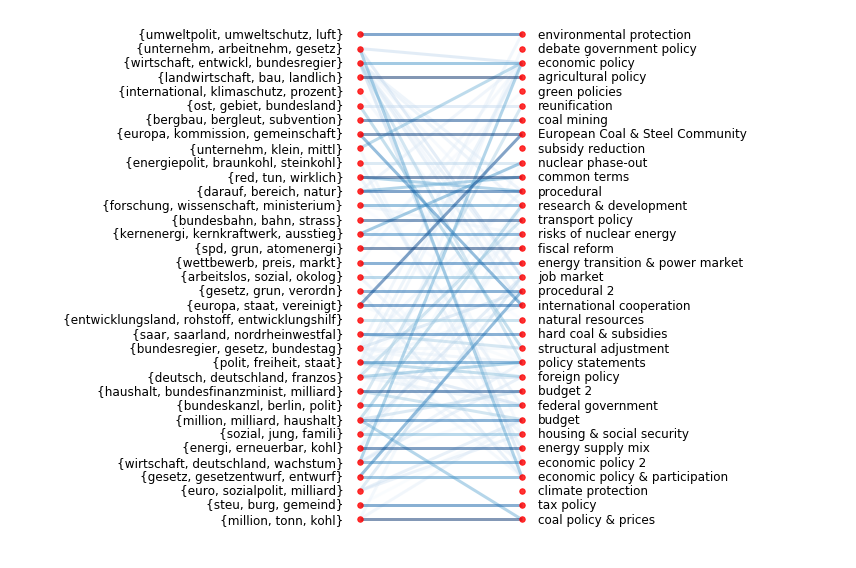

In [12]:
# !!! not correctly working at the moment for different Ks

# todo: in draw function, sort according to topic scores for one model

K_run_id = [run.K for run in RunStats.objects.filter(run_id__in=run_ids).order_by('run_id')]
if K_run_id[0] >= K_run_id[1]:
    corr_matrix = cos_sim[tk[0]:tk[1], :tk[0]]
    topics1 = [Topic.objects.get(id=topic_id) for topic_id in topic_ids_cos[tk[0]:tk[1]]]
    topics2 = [Topic.objects.get(id=topic_id) for topic_id in topic_ids_cos[0:tk[0]]]
else:
    corr_matrix = cos_sim[tk[0]:tk[1], :tk[0]].T
    topics1 = [Topic.objects.get(id=topic_id) for topic_id in topic_ids_cos[0:tk[0]]]
    topics2 = [Topic.objects.get(id=topic_id) for topic_id in topic_ids_cos[tk[0]:tk[1]]]

g = bipartite_graph_from_matrix(corr_matrix, topics1, topics2, match=True, threshold=0.2)

filename='cosine_similarity_graph_runs_{}_{}'.format(run_ids[0], run_ids[1])
draw_bipartite_topic_graph(g, filename=os.path.join(save_dir, filename), figsize=(12, 8))
print("saved as " + os.path.join(save_dir, filename))

In [31]:
# compare settings

fields = RunStats._meta.get_fields()
runs = RunStats.objects.filter(run_id__in=run_ids)

df = pd.DataFrame(list(runs.values()))

# get all field names
#for field in fields:
#    print(field.name)

df = df.transpose()
df['comparison'] = np.where(df[0] == df[1], True, False)
df

,0,1,comparison
K,35,35,True
alpha,0.01,0.01,True
batch_count,0,0,True
beta,None,None,False
citations,False,False,True
coherence,0.419955,0.463411,False
db,True,True,True
db_time,0,0,True
doc_topic_scaled_score,False,False,True
docs_seen,1,9167,False


# loop over pairs of model runs

In [25]:
from itertools import combinations
from scipy.special import binom

run_id_list = [2155, 2156, 2157] # top_chain_var = 0.01
run_id_list = [2155, 2158]
run_pairs = list(combinations(run_id_list, 2))

print(run_pairs)
print(len(run_pairs), binom(len(run_id_list), 2))

[(2155, 2158)]
1 1.0


word matrix density: 0.05582593758946464
shape: (90, 90)
matching sum:	38.59115946682549
max rows:	38.979058963052665
max cols:	40.771039270454004
matching sum:	38.59115946682549
max rows:	38.979058963052665
max cols:	40.771039270454004


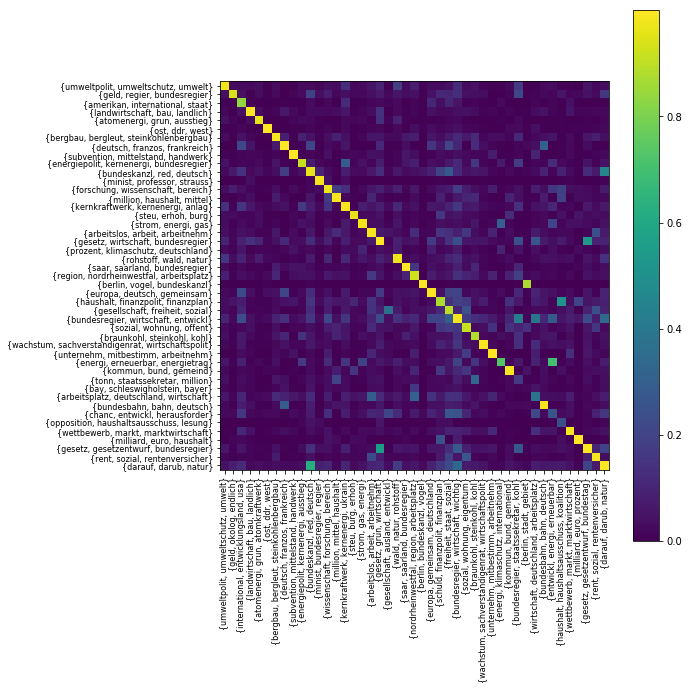

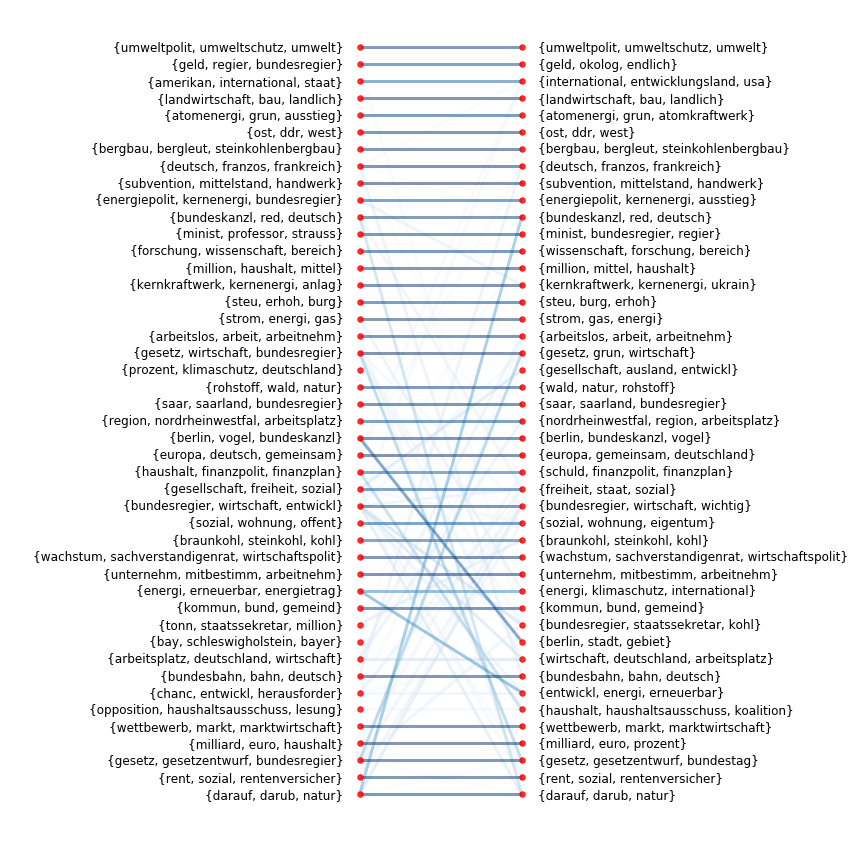

In [26]:
# todo: update with changed functions (see above)

for selected_run_ids in run_pairs:
    
    Ks = [RunStats.objects.get(run_id=run_id).K for run_id in selected_run_ids]
    tk = np.array(Ks).cumsum()
    
    cos_sim, topic_ids_cos = topic_cosine_similarity(selected_run_ids)
    
    topics1 = [Topic.objects.get(id=topic_id) for topic_id in topic_ids_cos[0:tk[0]]]
    topics2 = [Topic.objects.get(id=topic_id) for topic_id in topic_ids_cos[tk[0]:tk[1]]]

    filename = "cosine_similarity_matrix_runs_{}_{}.png".format(selected_run_ids[0], selected_run_ids[1])
    draw_score_matrix(cos_sim[tk[0]:tk[1], :tk[0]], topics2, topics1, match=True, filename=os.path.join(save_dir, filename))
    
    cos_sim_sorted, permutation = sort_matrix(cos_sim[tk[0]:tk[1], :tk[0]])

    g = bipartite_graph_from_matrix(cos_sim_sorted, threshold=0.2)

    perm_topic_list = [topics2[int(permutation[i])].title for i in range(Ks[1])]

    filename='cosine_similarity_graph_runs_{}_{}'.format(selected_run_ids[0], selected_run_ids[1])
    draw_bipartite_topic_graph(g, perm_topic_list, topics1, filename=os.path.join(save_dir, filename))

word matrix density: 0.048264744591956614
shape: (270, 270)


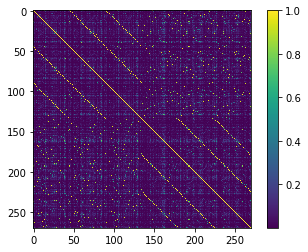

In [23]:
# similarity of all models
cos_sim, topic_ids_cos = topic_cosine_similarity(run_id_list)
plt.imshow(cos_sim)
plt.colorbar()

# compress folder

In [10]:
%%bash
zip -r plots/bipartite_graphs.zip plots/bipartite_graphs

  adding: plots/bipartite_graphs/ (stored 0%)
  adding: plots/bipartite_graphs/bipartite_topic_graph_Kohle_NM_K40_stopword_jahr_topword_score.pdf (deflated 27%)
  adding: plots/bipartite_graphs/bipartite_topic_graph_Kohle_LD_K30_K40_topword_score.png (deflated 3%)
  adding: plots/bipartite_graphs/cosine_similarity_graph_runs_2156_2157.png (deflated 5%)
  adding: plots/bipartite_graphs/bipartite_topic_graph_Kohle_LD_K40_stopword_jahr_topword_score.png (deflated 3%)
  adding: plots/bipartite_graphs/bipartite_topic_graph_Kohle_LD_K40_stopword_jahr_topword_score.pdf (deflated 21%)
  adding: plots/bipartite_graphs/bipartite_topic_graph_Kohle_NM_K40_stopword_frequency_5_topword_score.png (deflated 5%)
  adding: plots/bipartite_graphs/cosine_similarity_graph_runs_2155_2156.png (deflated 5%)
  adding: plots/bipartite_graphs/bipartite_topic_graph_Kohle_NM_K40_stopword_herr_topword_score.png (deflated 5%)
  adding: plots/bipartite_graphs/cosine_similarity_graph_runs_2155_2157.pdf (deflated 25%)
